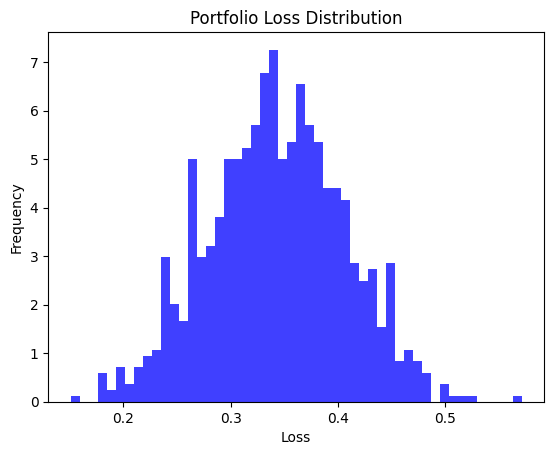

el: 0.34
ul: 0.06
var 99: 0.48
var 95: 0.45


In [25]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# fixed parameters
n_assets = 100 
n_simulations = 1000
rho = 0.2

# random parameters
#np.random.seed(10)
PD = np.random.uniform(0.01, 0.20, n_assets)
LGD = np.random.uniform(0.01, 0.05, n_assets)

# losses
losses = np.zeros(n_simulations)

# loss simulation
for i in range(n_simulations):
    correlated_randoms = np.dot(rho, np.random.normal(size=n_assets))
    adjusted_PD = np.percentile(correlated_randoms, PD * 100)
    default_events = correlated_randoms < adjusted_PD
    loss = np.sum(default_events * LGD)
    losses[i] = loss

# plot
plt.hist(losses, bins=50, density=True, alpha=0.75, color='blue')
plt.title('Portfolio Loss Distribution')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.show()

# el
EL = np.mean(losses)
print(f"el: {EL:.2f}")

# ul
UL = np.std(losses)
print(f"ul: {UL:.2f}")

# var 99%
VaR_99 = np.percentile(losses, 99)
print(f"var 99: {VaR_99:.2f}")

# var 95%
VaR_95 = np.percentile(losses, 95)
print(f"var 95: {VaR_95:.2f}")
